In [1]:
import rasterio as rio
import rioxarray
import numpy as np
import pandas as pd
import pickle
import geopandas as gpd
from rasterio.mask import mask
from rasterio.plot import show
import rioxarray as rxr
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import earthpy.plot as ep
import seaborn as sns
import jenkspy

In [2]:
prediction=pd.read_csv('Result/prediction_.csv',sep=';')

In [3]:
gpd_grid=gpd.read_file('Result/zonal_stat_grid_L8.gpkg',sep=';')

In [4]:
merged_pov=gpd_grid[['geometry']].merge(prediction[['pov_prediction_enet',
                                                    'pov_prediction_ridge']],left_index=True,right_index=True)

In [5]:
data=rio.open('Data/celebes_gcs_converted_L8.tif')
data_ntl=data.read()
df=pd.DataFrame(data_ntl[0].ravel())

In [6]:
rds = rioxarray.open_rasterio(
    "Data/celebes_gcs_converted_L8.tif",
)
rds=rds.to_dataframe('band_value').reset_index()

In [7]:
rds_gdf=gpd.GeoDataFrame(rds,geometry=gpd.points_from_xy(rds.x,rds.y))

In [8]:
merged_=gpd.sjoin(rds_gdf,merged_pov,op='intersects',how='left')

/tmp/ipykernel_16000/1962802299.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: GEOGCS["Undefined geographic SRS",DATUM["unknown", ...

  merged_=gpd.sjoin(rds_gdf,merged_pov,op='intersects',how='left')


In [9]:
merged_.describe()

,band,y,x,spatial_ref,band_value,index_right,pov_prediction_enet,pov_prediction_ridge
count,112420.0,112420.000000,112420.000000,112420.0,112420.000,12690.000000,12690.000000,12690.000000
mean,1.0,-1.090072,122.086585,0.0,826501.875,6344.500000,13.494745,13.456740
std,0.0,3.842783,2.914519,0.0,2316748.000,3663.431793,6.859813,4.532645
min,1.0,-7.728672,117.055771,0.0,255.000,0.000000,-23.545923,-6.006341
25%,1.0,-4.409372,119.571178,0.0,255.000,3172.250000,9.460158,10.794343
50%,1.0,-1.090072,122.086585,0.0,255.000,6344.500000,13.778422,13.773853
75%,1.0,2.229228,124.601992,0.0,255.000,9516.750000,17.967926,16.428301
max,1.0,5.548528,127.117399,0.0,7606050.000,12689.000000,40.352354,30.558378


In [10]:
merged_.loc[(~merged_.pov_prediction_ridge.isnull())& 
            (merged_.pov_prediction_ridge<0),'pov_prediction_ridge']=0

In [11]:
merged_.describe()

,band,y,x,spatial_ref,band_value,index_right,pov_prediction_enet,pov_prediction_ridge
count,112420.0,112420.000000,112420.000000,112420.0,112420.000,12690.000000,12690.000000,12690.000000
mean,1.0,-1.090072,122.086585,0.0,826501.875,6344.500000,13.494745,13.466393
std,0.0,3.842783,2.914519,0.0,2316748.000,3663.431793,6.859813,4.500563
min,1.0,-7.728672,117.055771,0.0,255.000,0.000000,-23.545923,0.000000
25%,1.0,-4.409372,119.571178,0.0,255.000,3172.250000,9.460158,10.794343
50%,1.0,-1.090072,122.086585,0.0,255.000,6344.500000,13.778422,13.773853
75%,1.0,2.229228,124.601992,0.0,255.000,9516.750000,17.967926,16.428301
max,1.0,5.548528,127.117399,0.0,7606050.000,12689.000000,40.352354,30.558378


In [12]:
np_data=merged_.pov_prediction_ridge.to_numpy().reshape(data_ntl[0].shape)

In [13]:
temp_ = rio.open('Data/celebes_gcs_converted_L8.tif')
temp = temp_.read(1)
profile = temp_.profile
profile.update(
    dtype=rio.float32,
    count=1,
    compress='lzw')
with rio.open('Result/celebes_predicted_ridge.tif','w',**profile) as dst2:
    dst2.write(np_data,1)
    dst2.close()

In [14]:
data_=rxr.open_rasterio('Result/celebes_predicted_ridge.tif', masked=True).squeeze()
data_min_value = np.nanmin(data_)
data_max_value = np.nanmax(data_)
print(data_min_value, data_max_value)

0.0 30.558378


In [15]:
data_pov=data_.to_dataframe('pov_prediction').reset_index()

<AxesSubplot:xlabel='pov_prediction', ylabel='Count'>

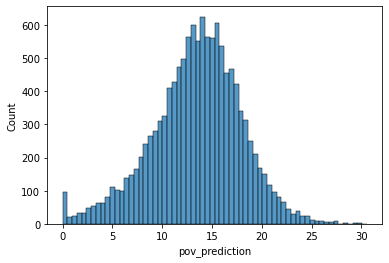

In [16]:
sns.histplot(data=data_pov,x='pov_prediction')

In [18]:
class_bins = [0, 5,10,15,20,40]
pre_data_class = xr.apply_ufunc(np.digitize,
                                     data_,
                                     class_bins)
pre_data_class_mask = pre_data_class.where(pre_data_class != 6)

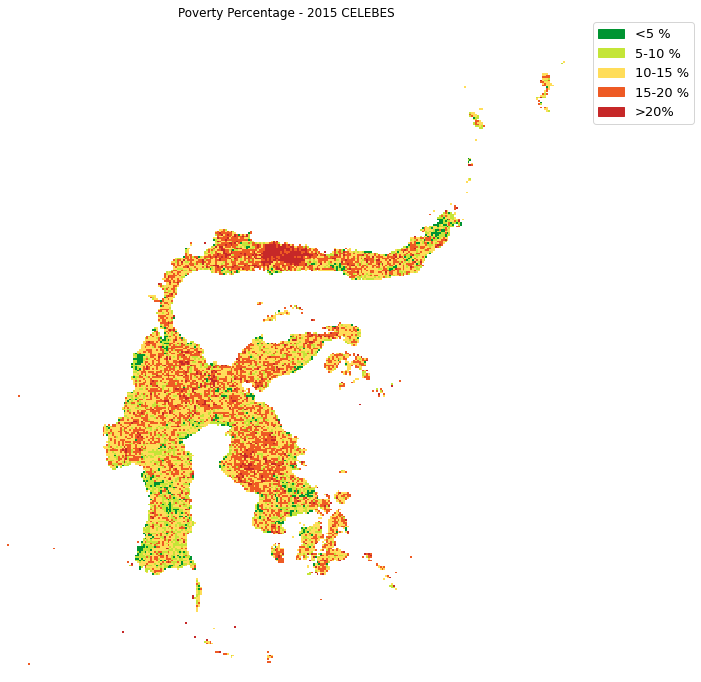

In [19]:
# Create a list of labels to use for your legend
labels =["<5 %","5-10 %","10-15 %",
          "15-20 %",">20%"]

# Create a colormap from a list of colors
colors =[ '#009432','#C4E538','#ffdd59',
          '#EE5A24','#c62828']
cmaps = ListedColormap(colors)

class_bins = [0.5, 1.5,2.5,3.5,4.5,5.5]
norm = BoundaryNorm(class_bins,len(colors))

# Plot newly classified and masked raster
f, ax = plt.subplots(figsize=(10, 12))
im = pre_data_class_mask.plot.imshow(cmap=cmaps,
                                      norm=norm,
                                      add_colorbar=False)
# Add legend using earthpy
ep.draw_legend(im,
               titles=labels)
ax.set(title="Poverty Percentage - 2015 CELEBES")
ax.set_axis_off()
plt.show()

<AxesSubplot:xlabel='pov_prediction', ylabel='Count'>

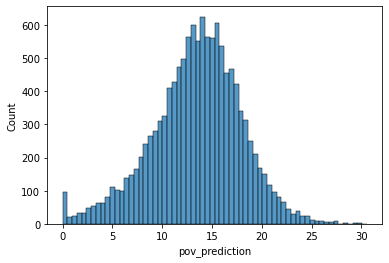

In [18]:
sns.histplot(data=data_pov,x='pov_prediction')

In [24]:
ypov_=data_pov.copy().dropna()

In [29]:
jenks_scale=jenkspy.jenks_breaks(list(ypov_['pov_prediction']), 5)

In [30]:
jenks_scale

[0.0,
 6.770161151885986,
 11.277471542358398,
 14.8125,
 18.632051467895508,
 30.558378219604492]

In [31]:
class_bins = jenks_scale
pre_data_class = xr.apply_ufunc(np.digitize,
                                     data_,
                                     class_bins)
pre_data_class_mask = pre_data_class.where(pre_data_class != 6)

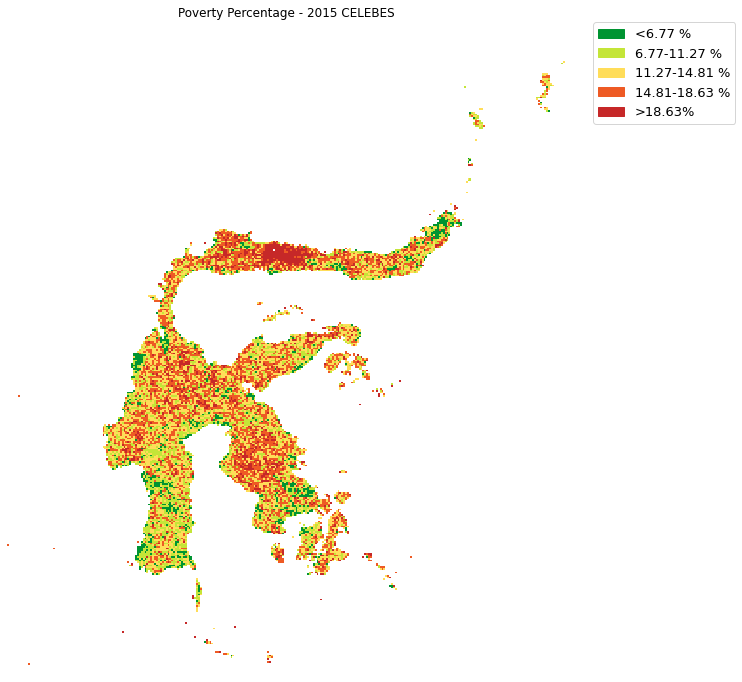

In [32]:
# Create a list of labels to use for your legend
labels =["<6.77 %","6.77-11.27 %","11.27-14.81 %",
          "14.81-18.63 %",">18.63%"]

# Create a colormap from a list of colors
colors =[ '#009432','#C4E538','#ffdd59',
          '#EE5A24','#c62828']
cmaps = ListedColormap(colors)

class_bins = [0.5, 1.5,2.5,3.5,4.5,5.5]
norm = BoundaryNorm(class_bins,len(colors))

# Plot newly classified and masked raster
f, ax = plt.subplots(figsize=(10, 12))
im = pre_data_class_mask.plot.imshow(cmap=cmaps,
                                      norm=norm,
                                      add_colorbar=False)
# Add legend using earthpy
ep.draw_legend(im,
               titles=labels)
ax.set(title="Poverty Percentage - 2015 CELEBES")
ax.set_axis_off()
plt.show()